## 1. Regression Methods

### 1.1.1 

date         0
SPX Index    0
dtype: int64


Text(0, 0.5, 'Log Price')

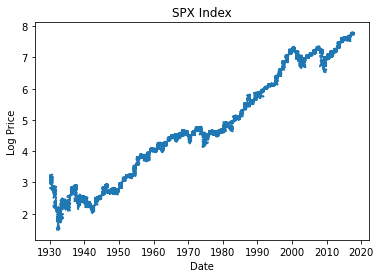

In [55]:
#Importing the necessary libraries and csv files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

%matplotlib inline
#Reading dates and prices data
px = pd.read_csv("priceData.csv", parse_dates =[0])
px.dropna(inplace=True)
print(px.isna().sum()) #calculate the nubmer of nan values)

#Perform log transform of the prices and plotting it
logpx = px.copy(deep=True)
logpx['Log Price'] = np.log(px['SPX Index'])
logpx.drop(['SPX Index'], axis = 1, inplace=True)

plt.plot(logpx['date'], logpx['Log Price'])
plt.title("SPX Index")
plt.xlabel("Date")
plt.ylabel("Log Price")


### 1.1.2

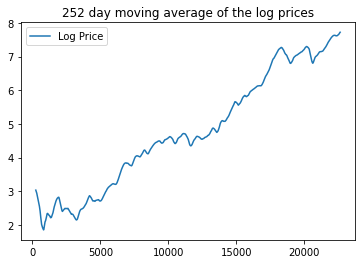

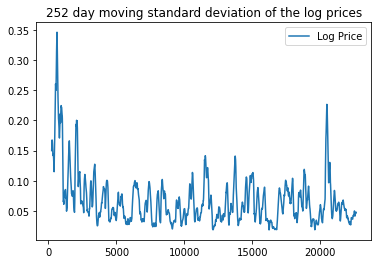

In [56]:
logpx.rolling(252).mean().plot()
plt.title("252 day moving average of the log prices")


logpx.rolling(252).std().plot()
plt.title("252 day moving standard deviation of the log prices")
plt.show()

### Comment on the stationarity of price time-series with reference to your figures.
A loose definition of stationarity is that the first order (mean) and second order(standard deviation) statistics of the distribution does not vary with time. 

The mean of the log prices are not stationary because the mean is clearly increasing over time.

The standard deviation of the log prices do not appear to have a trend however there are spikes within the signal which corresponds to market crashes or corretions. 

The signal is hence non-stationary.

### 1.13 Log Returns and Simple Returns

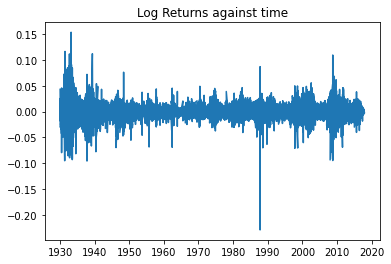

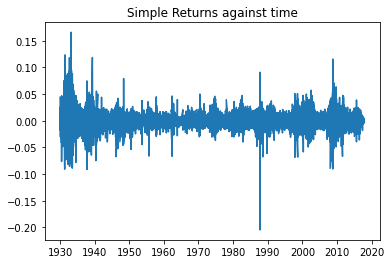

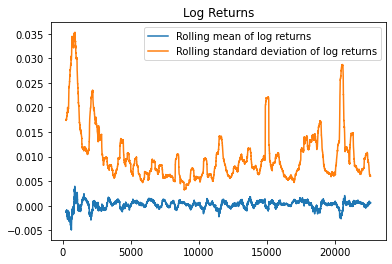

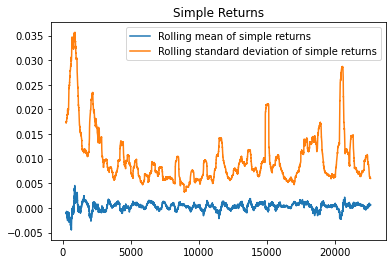

In [57]:
# Log returns
logpx['Log Returns'] = logpx['Log Price'].diff()

#Simple returns

px['Simple Returns'] = px['SPX Index'].pct_change()
plt.plot(logpx['date'],logpx['Log Returns'])
plt.title("Log Returns against time")

plt.figure()
plt.plot(px['date'], px['Simple Returns'])
plt.title("Simple Returns against time")

plt.figure()
logpx['Log Returns'].rolling(252).mean().plot()
logpx['Log Returns'].rolling(252).std().plot()
plt.title("Log Returns")
plt.legend(['Rolling mean of log returns','Rolling standard deviation of log returns'])

plt.figure()
px['Simple Returns'].rolling(252).mean().plot()
px['Simple Returns'].rolling(252).std().plot()

plt.title("Simple Returns")
plt.legend(['Rolling mean of simple returns','Rolling standard deviation of simple returns'])


The rolling mean for both the simple return and log returns have a small oscillatory behaviour around zero which implies a mean-reverting nature of this time-series.

### 1.1.4 Suitability of log returns over simple returns for signal processing practices.

First of all log is monotonically increasing and preserves relative ordering of numbers.
 
The taylor expansion of $log(1+x) = x - x^/2 + x^3/3....$ 

When x is small, $log(1+x) \approx x $

For short period returns, such as daily returns, the absolute value of it : $\frac{r_{t} - r_{t-1}}{r_{t-1}}$ tends to be small.

The log returns $log(r_{t}) - log(r_{t-1}) = log\frac{r_{t}}{r_{t-1}}$
Given that $\frac{r_{t}}{r_{t-1}}$ is small, we can approximate the log returns as $\frac{r_{t}}{r_{t-1}} - 1 = \frac{r_{t}- r_{t-1}}{r_{t-1}}$. That is the return is approximately the log-returns. 
 A consequence of that is that the log-returns are normally distributed which is handy given many statistical techniques presumes normality. Logarithms also provide better numeric stability for various algorithms. This can be further verified with the plots generated below.





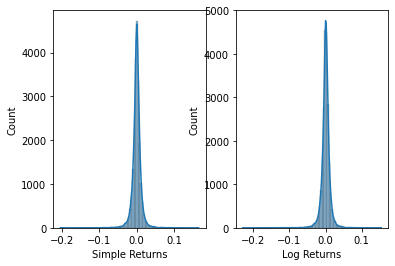

In [58]:
import scipy.stats as st
import seaborn as sns

fig, ax = plt.subplots(1,2)
sns.histplot(px['Simple Returns'], bins = 100, kde = True, ax = ax[0])
sns.histplot(logpx['Log Returns'], bins = 100, kde = True, ax = ax[1])
fig.show()







Another way to verify the 'Gaussianity' of the data is through the Jarque-Bera goodness of fit test. It measures whether sample data have the skewness and kurtosis matching a normal distribution, which has S (skewness) = 0 and C (kurtosis) = 3.

\begin {equation}
\mathit{JB} = {\frac{n}{6}} (S^{2} + \frac{1}{4}(K-3)^{2})
\end{equation}

Text(0, 0.5, 'Value of JB')

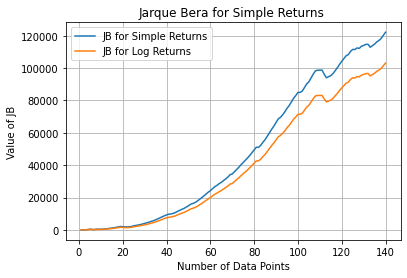

In [59]:
from scipy import stats 
start = 100 ; step = 100
steps = [i for i in range(start, len(px['Simple Returns']), step)]
num_data_points = list(map(lambda x: int(x/step), steps))
simple_JB = [stats.jarque_bera(px['Simple Returns'].dropna()[:s])[0] for s in steps]
log_JB = [stats.jarque_bera(logpx['Log Returns'].dropna()[:s])[0] for s in steps]

# How to plot with axes
fig, ax = plt.subplots()
ax.plot(num_data_points[:140],simple_JB[:140], label = 'JB for Simple Returns')
ax.plot(num_data_points[:140],log_JB[:140], label = 'JB for Log Returns')
ax.title.set_text('Jarque Bera for Simple Returns ')
ax.grid('on')
ax.legend()
ax.set_xlabel("Number of Data Points")
ax.set_ylabel("Value of JB")



It can be seen as the number of data points increases, the Jarque Bera statistic is increasing. It increases more gradually more gradually for log-returns which implies that log-returns deviate more slowly from a normal distribution proving our previous point of why it is widely used in the signal-processing domain.

### 1.1.5 £1 stock purchase example with log-returns

|$\Delta$ in Stock Price |Simple Returns |Log Returns|
|---|---|---|
|1.00 -> 2.00 | 1.00  | 0.69  |
|2.00 -> 1.00 | -0.5  | -0.69  |

Even though the stock price have no change relative to the initial price of a pound, the simple returns are unequal in magnitude as it is always relative to the starting price you are using. The log returns however are symmetric and sum up to zero
, giving us a clear understanding that the asset did change in value.

### 1.1.6 When should you use simple returns over log returns ? 

In the Markowitz portfolio optimization model, we aim to find a weight vector $\omega$ (vector that contains weighting of each asset) that minimizes the risk measured by the variance $\omega^{T}\Sigma\omega$.

When formulating such a portfolio, we often calculate the mean return by using the simple return vector $r$ which contains the mean return of each individual asset in the portfolio weighted by $\omega$. Hence the mean return can be expressed as $\bar{r} = \omega^{T}{r}$. If we were to use log-returns to model this problem, the expected log-returns will not be a simple weighted-average of the log-returns.


### 1.2 ARMA vs ARIMA models for financial applications

In [60]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR
import copy

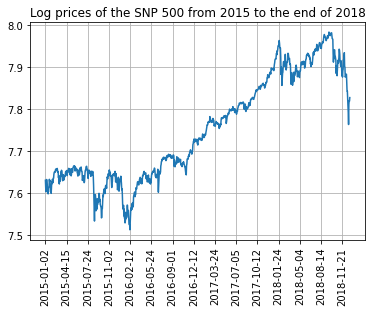

In [61]:
snp = pd.read_csv('snp_500_2015_2019.csv')
date = snp['Date']
snp.set_index(['Date'], inplace = True)
snp_close = snp['Close'].to_frame().apply(np.log)

plt.plot(snp_close)
plt.xticks(date[::70], rotation = 'vertical')
plt.title('Log prices of the SNP 500 from 2015 to the end of 2018')
plt.grid('on')


Based on the graph above, the log prices of the S&P 500 is non-stationary because there is a steady upward trend over time implying that the mean is increasing. The time-variant first and second order statistics suggest the unsuitability of the ARMA model for this specific time-series as it presumes stationarity. The ARIMA model however has an initial 'differencing step' that can be applied to eliminate the non-stationarity of the mean hence it would be more suitable to use the ARIMA model

### 1.2.2 Fitting an ARMA(1,0) to the S&P 500 index

The model parameter of this AR(1) model is 0.99736. The price signal is can then be formulated mathematically as : 
$$
\begin{equation*}
X_{t} = 0.99736X_{t-1} + \epsilon_{t}
\end{equation*}
$$

This model parameter 0.99736 is close to 1 which means the fitted signal is simply a random walk.

This explains why under close inspection, the fitted signal lags the true signal. The AR(1) model is not useful in practice because it just states that the price movement in the next time step is a random walk based on the price from the previous time step. Future movements are unpredictable and are equally likely to be up or down which is a naive forecast.

const     7.748867
ar.L1     0.997354
sigma2    0.000074
dtype: float64
Sum of Residuals 0.07770956975214016


Text(0.5, 0, 'Date')

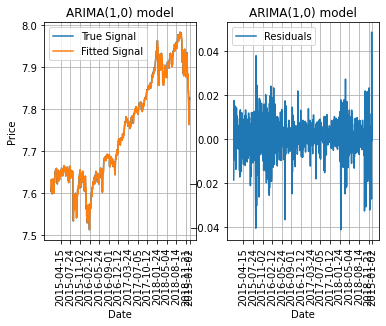

In [80]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']
model = ARIMA(snp_arma, order=(1,0,0)).fit()
snp_arma['Res'] = ARIMA(snp_arma, order=(1,0,0)).fit().resid #(AR,Differences,MA)
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

sum_of_residuals = snp_arma['Res'].sum()

print(model.params)
print("Sum of Residuals", sum_of_residuals)
fig, ax = plt.subplots(1,2)
ax[0].plot( snp_arma['True'][1:], label = 'True Signal')
ax[0].plot( snp_arma['Prediction'][1:], label = 'Fitted Signal')
ax[0].set_xticks(date[::70])
ax[0].set_xticklabels(date[::70],rotation = 90)
ax[0].title.set_text('ARIMA(1,0) model')
ax[0].grid('on')
ax[0].legend()
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")


ax[1].plot( snp_arma['Res'][1:], label = 'Residuals')
ax[1].set_xticks(date[::70])
ax[1].set_xticklabels(date[::70],rotation = 90)
ax[1].title.set_text('ARIMA(1,0) model')
ax[1].grid('on')
ax[1].legend()
ax[1].set_xlabel("Date")







### |1.2.3 Fitting an ARIMA(1,1,0) model with differencing

The ARIMA model with differencing removes sources of non-stationarity by applying a differencing step of order 1. The mathematical model for this section can be modelled as : 
$$
\begin{equation*}
\Delta X_{t} = -0.008170 * \Delta X_{t-1} + \epsilon_{t}
\end{equation*}
\\ 
\begin{equation*}
where \Delta X_{t} = X_{t} - X_{t-1}
\end{equation*}
$$

Since \epislon_{t} take values that are much larger than -0.008170 * $\Delta X_{t-1}$ we could approximate the expression such that $\Delta X_{t} \approx \epsilon_{t}$ which reesults in the same conclusion as of 1.2.2.


Sum of residuals for ARIMA 7.828324256613874
ar.L1    -0.008170
sigma2    0.000074
dtype: float64


Text(0.5, 0, 'Date')

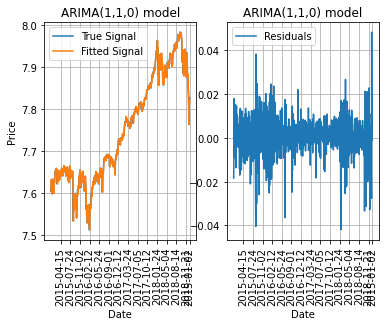

In [81]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ['True']
model_arima = ARIMA(snp_arima, order=(1,1,0)).fit()
snp_arima['Res'] = ARIMA(snp_arima, order=(1,1,0)).fit().resid #(AR,Differences,MA)
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

sum_of_residuals = snp_arima['Res'].sum()
print("Sum of residuals for ARIMA", sum_of_residuals)
print(model_arima.params)
fig, ax = plt.subplots(1,2)
ax[0].plot( snp_arima['True'][1:], label = 'True Signal')
ax[0].plot( snp_arima['Prediction'][1:], label = 'Fitted Signal')
ax[0].set_xticks(date[::70])
ax[0].set_xticklabels(date[::70],rotation = 90)
ax[0].title.set_text('ARIMA(1,1,0) model')
ax[0].grid('on')
ax[0].legend()
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")


ax[1].plot( snp_arima['Res'][1:], label = 'Residuals')
ax[1].set_xticks(date[::70])
ax[1].set_xticklabels(date[::70],rotation = 90)
ax[1].title.set_text('ARIMA(1,1,0) model')
ax[1].grid('on')
ax[1].legend()
ax[1].set_xlabel("Date")


### Vector Autoregressive (VAR) models
